In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

In [2]:
current_dir = Path.cwd()
project_root = current_dir.parent.parent 
model_path = project_root / "models" / "best_model_pipeline.pkl"

print(f"Loading model from: {model_path}")

Loading model from: c:\Users\Anjori Sarabhai\Desktop\anjori\Delhi_AQI_Project\models\best_model_pipeline.pkl


In [3]:
# 2. Load the Model Pipeline
try:
    model_pipeline = joblib.load(model_path)
    print("✓ Model loaded successfully")
except FileNotFoundError:
    print("❌ Error: Model file not found. Check the path.")
    raise

✓ Model loaded successfully


In [4]:
# 3. Extract Feature Names and Importances
# We need to dig into the pipeline steps
# Step 1: 'preprocessor' (ColumnTransformer)
# Step 2: 'model' (RandomForestRegressor)

preprocessor = model_pipeline.named_steps['preprocessor']
rf_model = model_pipeline.named_steps['model']

# Get feature names generated by OneHotEncoder and the passed-through numerical columns
feature_names = preprocessor.get_feature_names_out()

# Get importances from the Random Forest
importances = rf_model.feature_importances_

In [5]:
# 4. Create a Clean DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Clean up the messy feature names created by the pipeline
# e.g., "num__distance_to_major_road" -> "distance_to_major_road"
feat_imp_df['Feature'] = feat_imp_df['Feature'].str.replace('num__', '').str.replace('cat__', '')

C:\Users\Anjori Sarabhai\AppData\Local\Temp\ipykernel_21608\2526813886.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(30), x='Importance', y='Feature', palette='viridis')


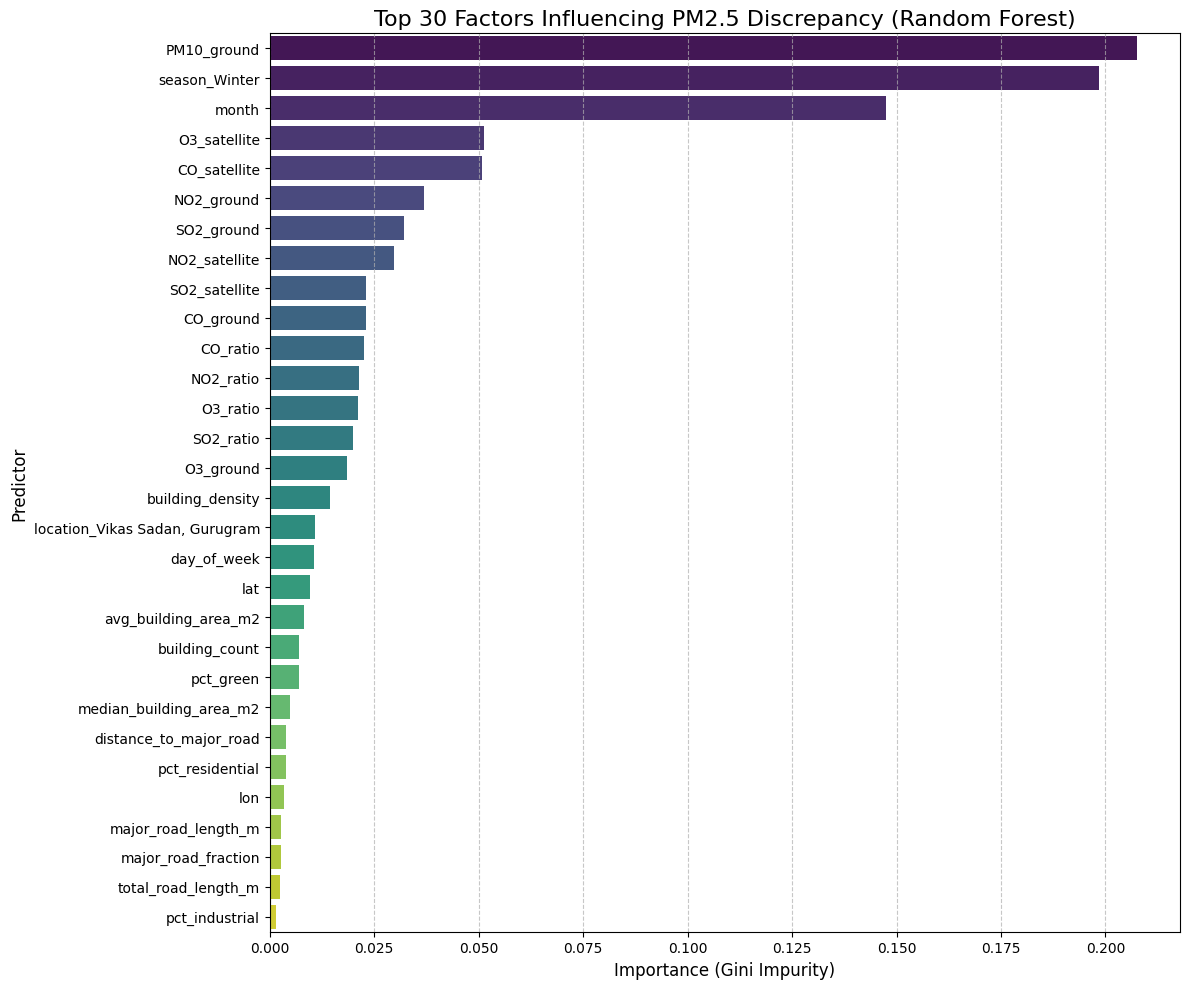

In [9]:
# 5. Visualize the Top 15 Drivers
plt.figure(figsize=(12, 10))
sns.barplot(data=feat_imp_df.head(30), x='Importance', y='Feature', palette='viridis')

plt.title('Top 30 Factors Influencing PM2.5 Discrepancy (Random Forest)', fontsize=16)
plt.xlabel('Importance (Gini Impurity)', fontsize=12)
plt.ylabel('Predictor', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# 6. Print the exact values for the paper
print("\n--- Top 20 Drivers of Discrepancy ---")
print(feat_imp_df.head(20))


--- Top 20 Drivers of Discrepancy ---
                           Feature  Importance
4                      PM10_ground    0.207470
37                   season_Winter    0.198391
22                           month    0.147428
3                     O3_satellite    0.051170
2                     CO_satellite    0.050896
5                       NO2_ground    0.036940
6                       SO2_ground    0.032195
0                    NO2_satellite    0.029768
1                    SO2_satellite    0.023140
7                        CO_ground    0.022973
26                        CO_ratio    0.022615
24                       NO2_ratio    0.021290
27                        O3_ratio    0.021079
25                       SO2_ratio    0.019887
8                        O3_ground    0.018412
17                building_density    0.014390
34  location_Vikas Sadan, Gurugram    0.010845
23                     day_of_week    0.010499
9                              lat    0.009746
18            avg_bui

## Observations: Key Drivers of PM2.5 Discrepancy (Random Forest Feature Importance)

The feature importance analysis reveals a clear hierarchy of drivers explaining the mismatch between satellite-derived proxy values and actual ground-level $PM_{2.5}$ concentrations. The model relies on three distinct tiers of information:

### 1. Primary Drivers: Seasonality and Particulate Load (The "State" Factors)
The top three features dominate the model's predictive power, accounting for over **55% of the total importance**.

* **`PM10_ground` (0.21):** This is the single strongest predictor. Since $PM_{2.5}$ is a physical subset of $PM_{10}$, this high importance confirms that the discrepancy is deeply linked to the overall existing particulate load. When coarse dust is high, the fine particulate gap widens in a predictable way.
* **`season_Winter` (0.20) & `month` (0.15):** Seasonality is the dominant physical mechanism. The massive importance of **Winter** confirms the **"Inversion Hypothesis"**: during Delhi's winters, the Planetary Boundary Layer (PBL) collapses, trapping pollutants in a thin, dense layer near the ground. Satellites, which measure the total vertical column, underestimate this surface intensity. The model effectively learns to apply a "Winter Correction Factor."

### 2. Secondary Drivers: Satellite Signals
Satellite data contributes significantly (ranks 4-5), validating the use of remote sensing beyond just the Aerosol Index.

* **`O3_satellite` (0.05) & `CO_satellite` (0.05):** These rank higher than satellite $NO_2$ or $SO_2$. This suggests that Ozone and Carbon Monoxide column densities act as the best chemical proxies for the atmospheric conditions (combustion levels and photochemical activity) that drive $PM_{2.5}$ formation in this region.

### 3. Tertiary Drivers: Urban Morphology & Hyperlocal Context
While ground and seasonal factors dominate, **hyperlocal features** appear in the top 20, proving that urban form plays a measurable role in the discrepancy.

* **`building_density` (Rank ~17):** This is the **highest-ranking hyperlocal feature**, outperforming roads and green space. This supports the **"Street Canyon Effect"** hypothesis: areas with higher building density reduce wind speed at ground level, "trapping" pollutants. This causes ground sensors to read much higher than the satellite (which sees the open air above), leading to a high discrepancy.
* **The "PM10 Masking" Effect:** Features like `distance_to_major_road` and `pct_green` appear lower in the list. This is likely because `PM10_ground` acts as a proxy for them—if `PM10` is high, the model already "knows" there is likely heavy traffic or dust, effectively masking the direct signal of the road network features.
* **`location_Vikas Sadan`:** The specific importance of this location likely flags the sensor anomalies (flat-lining) identified during EDA, which the model learned to treat as a distinct pattern.

### Conclusion
The discrepancy between satellite and ground data is not random; it follows a structured physical hierarchy. It is a function of **Meteorology (Season)** $\rightarrow$ **Existing Dust Load (PM10)** $\rightarrow$ **Urban Form (Building Density)**.

A robust correction model for Delhi NCR must prioritize dynamic seasonal adjustments first, followed by corrections for urban morphology (specifically building density) to account for trapped pollution.